<a href="https://colab.research.google.com/github/saratkv/HandsOn_Unsupervised_Learning_with_Python/blob/master/chapter02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download from: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
# Change <data_folder> with the actual path
#%mkdir /content/data
#%cd /content/data
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data



In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import contingency_matrix


# For reproducibility
np.random.seed(1000)



bc_dataset_path = '/content/data/wdbc.data'

bc_dataset_columns = ['id','diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
                      'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
                      'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                      'radius_se','texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                      'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
                      'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
                      'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
                      'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
                     

In [0]:
    # Load the dataset
    df = pd.read_csv(bc_dataset_path, index_col=0, names=bc_dataset_columns).fillna(0.0)

    # Show the overall statistical properties
    print(df.describe())

    # Show the pair-plot
    sns.set()

    with sns.plotting_context("notebook", font_scale=1.2):
        sns.pairplot(df,
                     vars=['perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean'],
                     hue="diagnosis")

    plt.show()
    

In [0]:
 # Project the dataset on a bidimensional plane
    cdf = df.drop(['diagnosis'], axis=1)

    tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
    data_tsne = tsne.fit_transform(cdf)

    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=cdf.index)
    dff = pd.concat([df, df_tsne], axis=1)

    # Show the diagram
    fig, ax = plt.subplots(figsize=(18, 11))

    with sns.plotting_context("notebook", font_scale=1.5):
        sns.scatterplot(x='x',
                        y='y',
                        hue='diagnosis',
                        size='area_mean',
                        style='diagnosis',
                        sizes=(30, 400),
                        palette=sns.color_palette("husl", 2),
                        data=dff,
                        ax=ax)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

    plt.show()
    

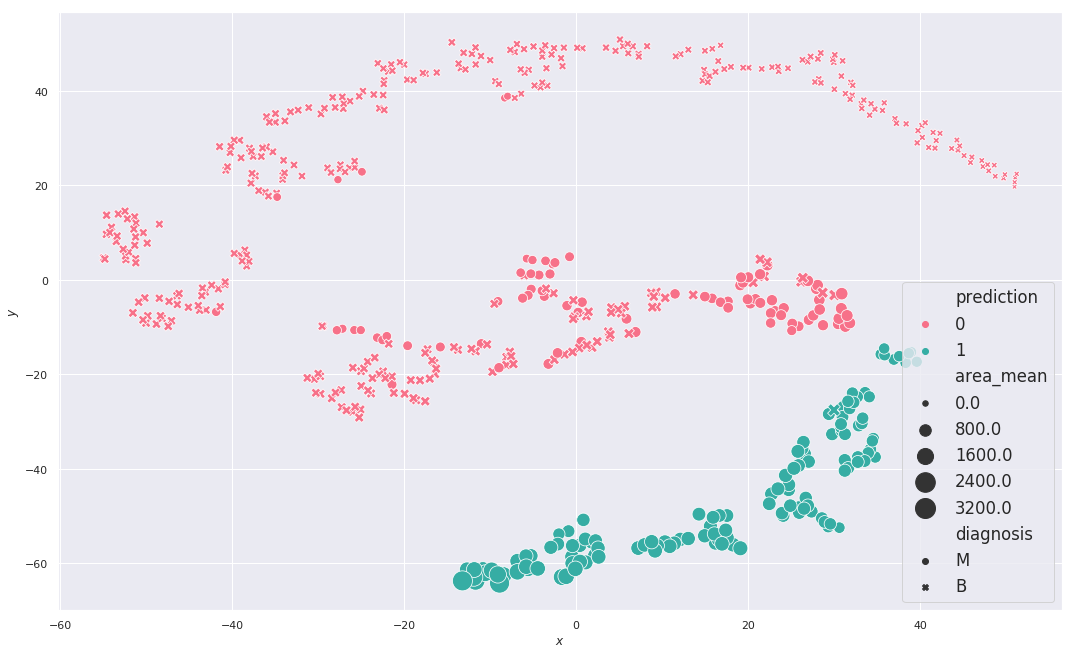

In [9]:
    # Perform a K-Means clustering with K=2
    km = KMeans(n_clusters=2, max_iter=1000, random_state=1000)
    Y_pred = km.fit_predict(cdf)

    df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
    kmdff = pd.concat([dff, df_km], axis=1)

    # Show the clustering result
    fig, ax = plt.subplots(figsize=(18, 11))

    with sns.plotting_context("notebook", font_scale=1.5):
        sns.scatterplot(x='x',
                        y='y',
                        hue='prediction',
                        size='area_mean',
                        style='diagnosis',
                        sizes=(30, 400),
                        palette=sns.color_palette("husl", 2),
                        data=kmdff,
                        ax=ax)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

    plt.show()
    

In [0]:
    # Compute the inertia
    inertias = []

    for i in range(2, 51):
        km = KMeans(n_clusters=i, max_iter=1000, random_state=1000)
        km.fit(cdf)
        inertias.append(km.inertia_)

    # Show the plot inertia vs. no. clusters
    fig, ax = plt.subplots(figsize=(18, 8))

    ax.plot(np.arange(2, 51, 1), inertias)
    ax.set_xlabel('Number of clusters', fontsize=14)
    ax.set_ylabel('Inertia', fontsize=14)
    ax.set_xticks(np.arange(2, 51, 2))

    plt.show()
    

In [0]:
    nb_clusters = [2, 4, 6, 8]
    mapping = [(0, 0), (0, 1), (1, 0), (1, 1)]

    # Show the silhouette plots
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    for i, n in enumerate(nb_clusters):
        km = KMeans(n_clusters=n, random_state=1000)
        Y = km.fit_predict(cdf)
        df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
        kmdff = pd.concat([dff, df_km], axis=1)

        silhouette_values = silhouette_samples(cdf, kmdff['prediction'])

        ax[mapping[i]].set_xticks([-0.15, 0.0, 0.25, 0.5, 0.75, 1.0])
        ax[mapping[i]].set_yticks([])
        ax[mapping[i]].set_title('%d clusters' % n)
        ax[mapping[i]].set_xlim([-0.15, 1])
        y_lower = 20

        for t in range(n):
            ct_values = silhouette_values[Y == t]
            ct_values.sort()

            y_upper = y_lower + ct_values.shape[0]

            color = cm.Accent(float(t) / n)
            ax[mapping[i]].fill_betweenx(np.arange(y_lower, y_upper), 0, ct_values, facecolor=color, edgecolor=color)

            y_lower = y_upper + 20

    plt.show()

In [0]:
    # Compute the other metrics for K=2
    km = KMeans(n_clusters=2, max_iter=1000, random_state=1000)
    Y_pred = km.fit_predict(cdf)
    df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
    kmdff = pd.concat([dff, df_km], axis=1)

    print('Completeness: {}'.format(completeness_score(kmdff['diagnosis'], kmdff['prediction'])))
    print('Homogeneity: {}'.format(homogeneity_score(kmdff['diagnosis'], kmdff['prediction'])))
    print('V-Score: {}'.format(v_measure_score(kmdff['diagnosis'], kmdff['prediction'])))
    print('Adj. Mutual info: {}'.format(adjusted_mutual_info_score(kmdff['diagnosis'], kmdff['prediction'])))
    print('Adj. Rand score: {}'.format(adjusted_rand_score(kmdff['diagnosis'], kmdff['prediction'])))

    # Compute and show the contingency matrix
    cm = contingency_matrix(kmdff['diagnosis'].apply(lambda x: 0 if x == 'B' else 1), kmdff['prediction'])

    fig, ax = plt.subplots(figsize=(8, 6))

    with sns.plotting_context("notebook", font_scale=1.5):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)

    plt.show()

In [0]:
    # Perform a K-Means clustering with K=8
    km = KMeans(n_clusters=8, max_iter=1000, random_state=1000)
    Y_pred = km.fit_predict(cdf)

    df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
    kmdff = pd.concat([dff, df_km], axis=1)

    # Show the result
    fig, ax = plt.subplots(figsize=(18, 11))

    with sns.plotting_context("notebook", font_scale=1.5):
        sns.scatterplot(x='x',
                        y='y',
                        hue='prediction',
                        size='area_mean',
                        style='diagnosis',
                        sizes=(30, 400),
                        palette=sns.color_palette("husl", 8),
                        data=kmdff,
                        ax=ax)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

    plt.show()
    

In [0]:
    # Show the statistical description of two clusters
    sdff = dff[(dff.x > -25.0) & (dff.x < 30.0) & (dff.y > -60.0) & (dff.y < -40.0)]
    print(sdff[['perimeter_mean', 'area_mean', 'smoothness_mean',
                'concavity_mean', 'symmetry_mean']].describe())

    sdff = dff[(dff.x > -10.0) & (dff.y > 20.0) & (dff.y < 50.0)]
    print(sdff[['perimeter_mean', 'area_mean', 'smoothness_mean',
                'concavity_mean', 'symmetry_mean']].describe())
    